# Age Recognision
Goal of this notebook is to create model for predicting age from an image.

In [1]:
# few imports
import numpy as np
import os
import pandas as pd
import sklearn
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices("GPU")
for gp in gpus:
    tf.config.experimental.set_memory_growth(gp, True)

Num GPUs Available:  1


# useful functions for later

In [3]:
IMG_SIZE = 200
BATCH_SIZE = 24
NUM_EPOCHS = 20

In [4]:
# useful functions

def process_image(image_path,img_size=IMG_SIZE):
    '''
    Function takes as an input a string called image_path and optionally img_size,
    it gets an image from the path, 
    turning it into a tensor and resizing it to the square, img_size x img_size.
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3) # turning into a tensor
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[img_size,img_size]) # resizing
    return image
def process_label_entry(label):
    return (label == np.array(["YOUNG","MIDDLE","OLD"])).astype(int)
# we are using this function in order to do mini batching
def get_tuples(image_path,label):
    """
    returns (image,label) tuples,
    where label is 0 when image is fake and 1 when it's real
    """
    image = process_image(image_path,IMG_SIZE)
    
    return (image,label)

def get_batch(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    """
    Create batches of data out of image (X - filepath) and label (y - labels) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    side note: it's easier to shuffle filepaths rather than whole images
    """
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # every filepath as new example
        data_batch = data.map(process_image).batch(BATCH_SIZE) # from filename to image, then get a batch
        return data_batch
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        data_batch = data.map(get_tuples).batch(BATCH_SIZE)
        return data_batch
    else:
        print("Creating training data batches...")
        
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        
        # shuffling pathnames and labels is far easier than shuffling images
        data = data.shuffle(buffer_size=len(X))
        
        # get (image,label) tuples
        data = data.map(get_tuples)
        
        # Turning into batch
        data_batch = data.batch(BATCH_SIZE)
        
        return data_batch
    
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs_range,acc,label='Training accuracy')
    plt.plot(epochs_range,val_acc,label='Validation accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training loss')
    plt.plot(epochs_range,val_loss,label='Validation loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
def plot_history_numeric(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))
    plt.plot(epochs_range,loss,label='Training loss')
    plt.plot(epochs_range,val_loss,label='Validation loss')
    plt.legend()
    plt.title('Training and Validation Loss')
# Create a function for viewing images in a data batch

def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    for i in range(24):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(labels[i])
        # Turn the grid lines off
        plt.tight_layout()
        plt.axis("off")


# importing entry data for transfer learning

In [5]:
df_entry = pd.read_csv('./dataset_for_entry_learning/train.csv')
df_entry

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


In [6]:
# import the data

folder_path = './dataset_for_entry_learning/Train'
X_entry,y_entry = [],[]

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        X_entry.append(image_path)
        y_entry.append(process_label_entry(df_entry.loc[df_entry['ID'] == filename]['Class'].values[0]))


## visualising data

[0 1 0]


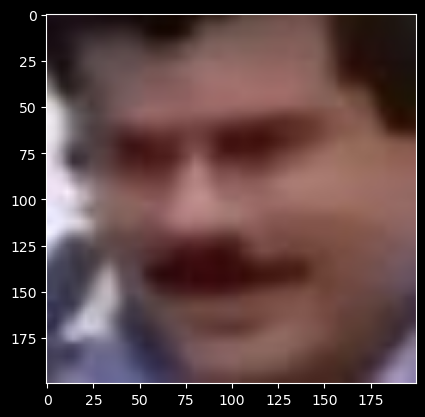

[1 0 0]


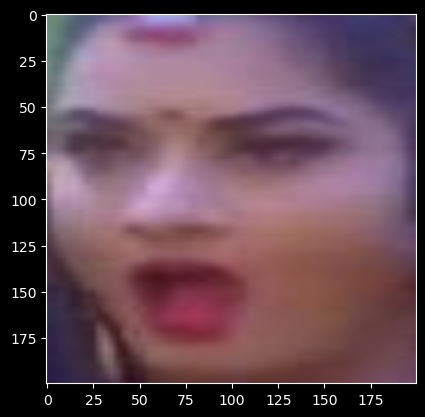

[1 0 0]


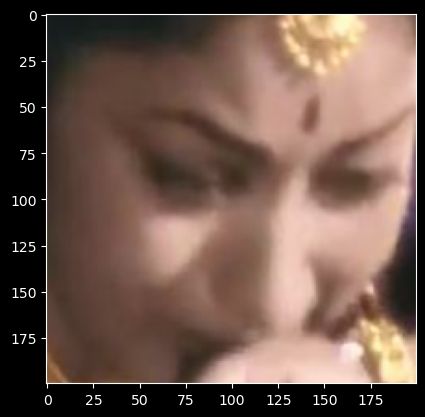

[1 0 0]


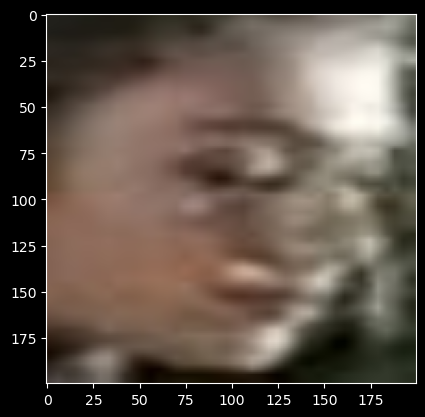

[0 0 1]


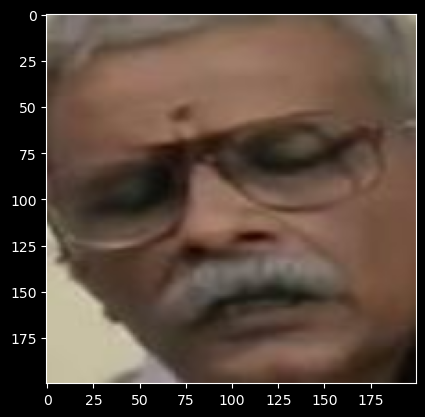

In [7]:
examples = [(process_image(X_entry[i]),y_entry[i]) for i in range(5,10)]
plt.style.use('dark_background')
for x,y in examples:
    print(y)
    plt.imshow(x)
    plt.show()

not as good quality as imagined but it will be sufficient for our entry model, to kickstart our proper model

# importing the dataset
Importing data that I will use in a proper model

In [11]:
import re

folder_path = './dataset'
X,y = [],[]

for filename in os.listdir(folder_path):
    label = re.findall('^(\d{1,3})\_',filename) # searching for age
    label = int(list(filter(None, label))[0]) # extracting it as int
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        X.append(image_path)
        y.append(label)

In [12]:
print(len(X))
print(len(y))

19548
19548


## visualising data

100


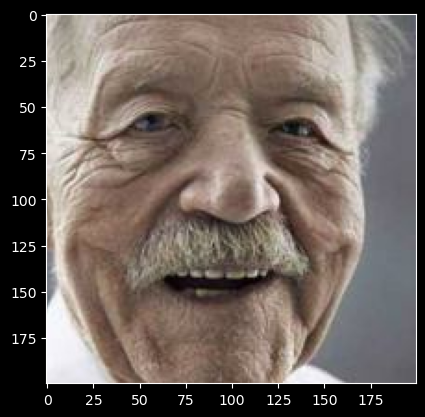

101


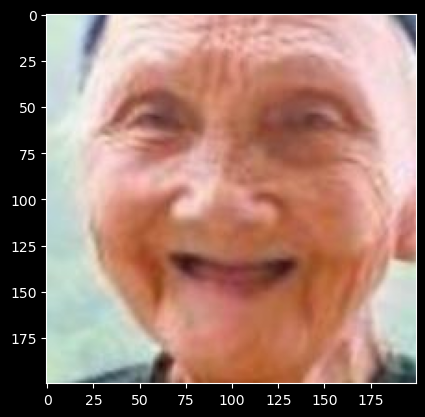

10


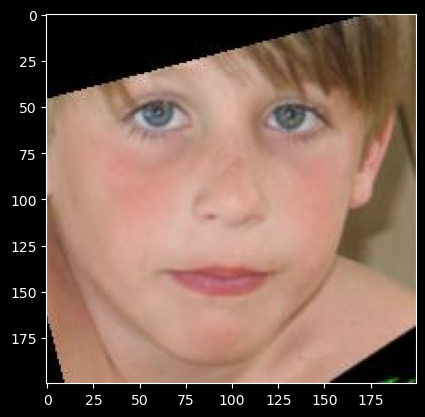

10


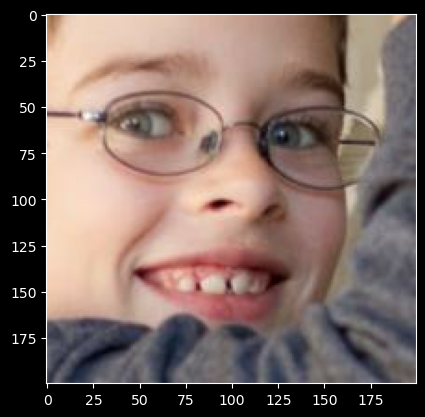

10


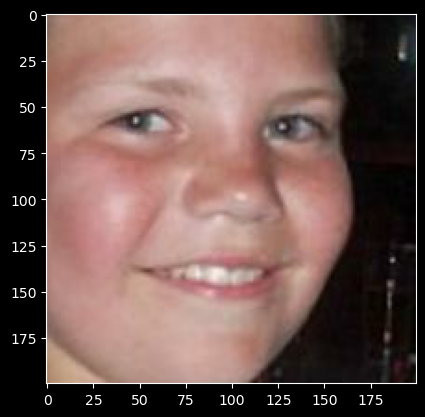

In [13]:
examples = [(process_image(X[i]),y[i]) for i in range(0,50,10)]
for x_i,y_i in examples:
    print(y_i)
    plt.imshow(x_i)
    plt.show()

# importing the second (augmented from first dataset) dataset

In [14]:
folder_path = 'augmented_images'

for filename in os.listdir(folder_path):
    label = re.findall('^(\d{1,3})\_',filename) # searching for age
    label = int(label[0]) # extracting it as int
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        X.append(image_path)
        y.append(label)

In [15]:
print(len(X))
print(len(y))

57451
57451


## visualising data

13


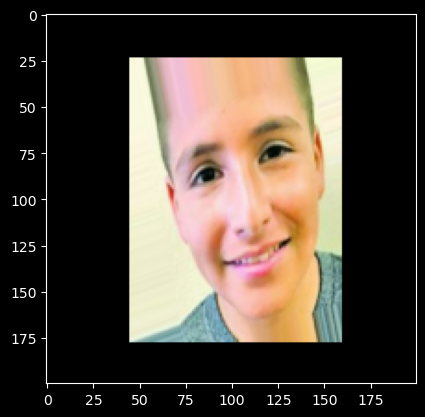

13


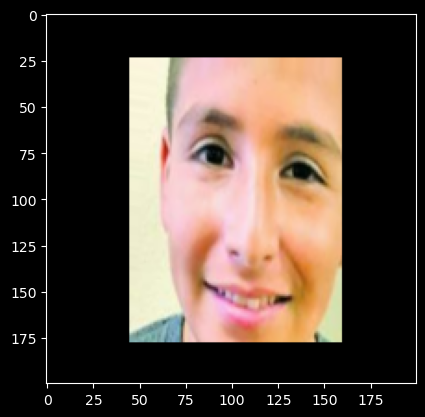

13


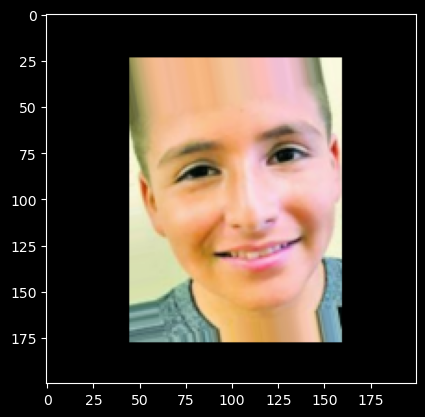

13


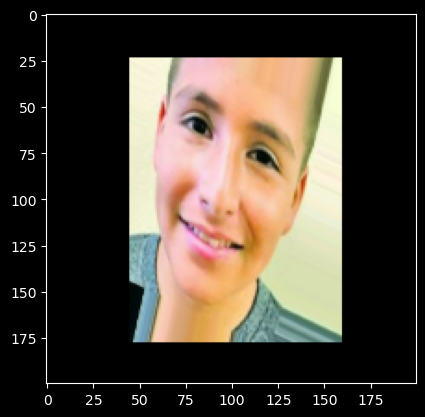

13


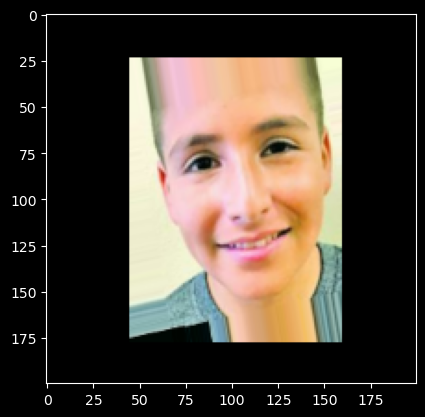

In [16]:
examples = [(process_image(X[i]),y[i]) for i in range(20_000,20_100,20)]

for x_i,y_i in examples:
    print(y_i)
    plt.imshow(x_i)
    plt.show()

# importing test dataset

In [17]:
folder_path = './test_data'
X_test,y_test = [],[]
test_images = []

for filename in os.listdir(folder_path):
    label = re.findall('^(\d{1,3})\_',filename) # searching for age
    label = int(label[0]) # extracting it as int
    
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        X_test.append(image_path)
        test_images.append(process_image(image_path))
        y_test.append(label)
        
test_images = np.array(test_images)

In [19]:
print(len(X_test),len(y_test))

3450 3450


# entry model
After first learning I will change last layer to fit new data, for predicting a number (age)

In [20]:
from sklearn.model_selection import train_test_split
X_entry_train, X_entry_val, y_entry_train, y_entry_val = train_test_split(X_entry,y_entry,test_size=0.2)

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D,Conv2D,Dense,Flatten,Dropout,Input

entry_model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.65),
    Dense(256, activation='relu'),
    Dense(3, activation='softmax')
])
# or
#entry_model = tf.keras.models.load_model('./models')

In [52]:
from tensorflow.keras.losses import CategoricalCrossentropy
entry_model.compile(optimizer='adam',loss=CategoricalCrossentropy(),metrics=['accuracy','Recall'])
entry_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 25, 128)     

In [53]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping

callback_one = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001,restore_best_weights=True)

In [54]:
data_train_entry = get_batch(X_entry_train,y_entry_train)
data_valid_entry = get_batch(X_entry_val,y_entry_val,valid_data=True)

Creating training data batches...
Creating validation data batches...


# entry model training

In [55]:
history = entry_model.fit(x=data_train_entry,
         epochs=NUM_EPOCHS*2,
         validation_data=data_valid_entry,
         callbacks=[callback_one])

Epoch 1/40
664/664 [==============================] - 13s 19ms/step - loss: 0.8504 - accuracy: 0.6098 - recall: 0.5106 - val_loss: 0.7718 - val_accuracy: 0.6575 - val_recall: 0.6213
Epoch 2/40
664/664 [==============================] - 12s 18ms/step - loss: 0.7558 - accuracy: 0.6626 - recall: 0.5939 - val_loss: 0.7371 - val_accuracy: 0.6733 - val_recall: 0.6185
Epoch 3/40
664/664 [==============================] - 12s 18ms/step - loss: 0.6968 - accuracy: 0.6944 - recall: 0.6314 - val_loss: 0.7017 - val_accuracy: 0.7042 - val_recall: 0.6303
Epoch 4/40
664/664 [==============================] - 12s 18ms/step - loss: 0.6431 - accuracy: 0.7216 - recall: 0.6755 - val_loss: 0.6661 - val_accuracy: 0.7187 - val_recall: 0.6763
Epoch 5/40
664/664 [==============================] - 12s 18ms/step - loss: 0.5868 - accuracy: 0.7486 - recall: 0.7133 - val_loss: 0.6259 - val_accuracy: 0.7383 - val_recall: 0.7054
Epoch 6/40
664/664 [==============================] - 12s 18ms/step - loss: 0.5104 - accur

INFO:tensorflow:Assets written to: ./models\assets


INFO:tensorflow:Assets written to: ./models\assets


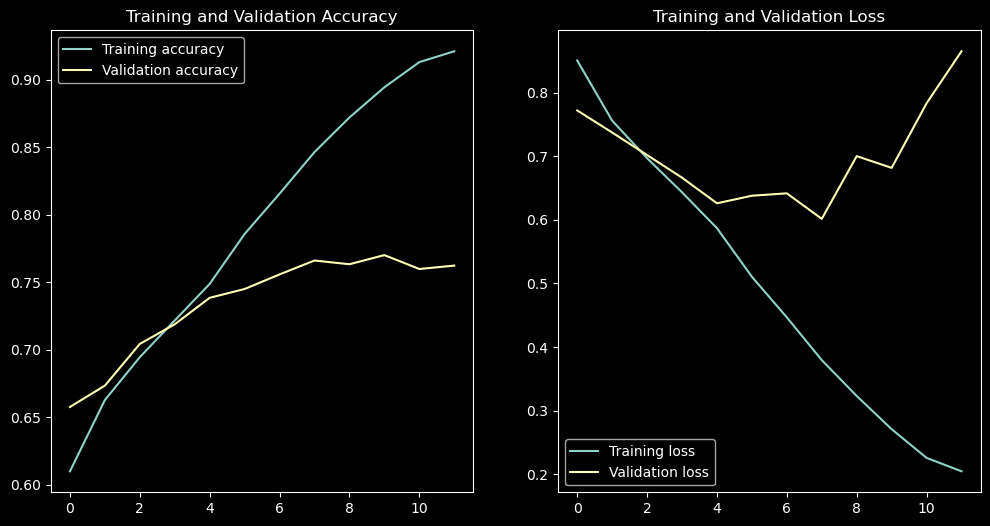

In [56]:
#comment if model was already loaded
entry_model.save('./models')
plot_history(history)

# model training after pretrain

## data dividing

In [57]:
print(len(X),len(y))

57451 57451


In [58]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15) # get X_train,y_train
data_train = get_batch(X_train,y_train)
data_valid = get_batch(X_val,y_val)

Creating training data batches...
Creating training data batches...


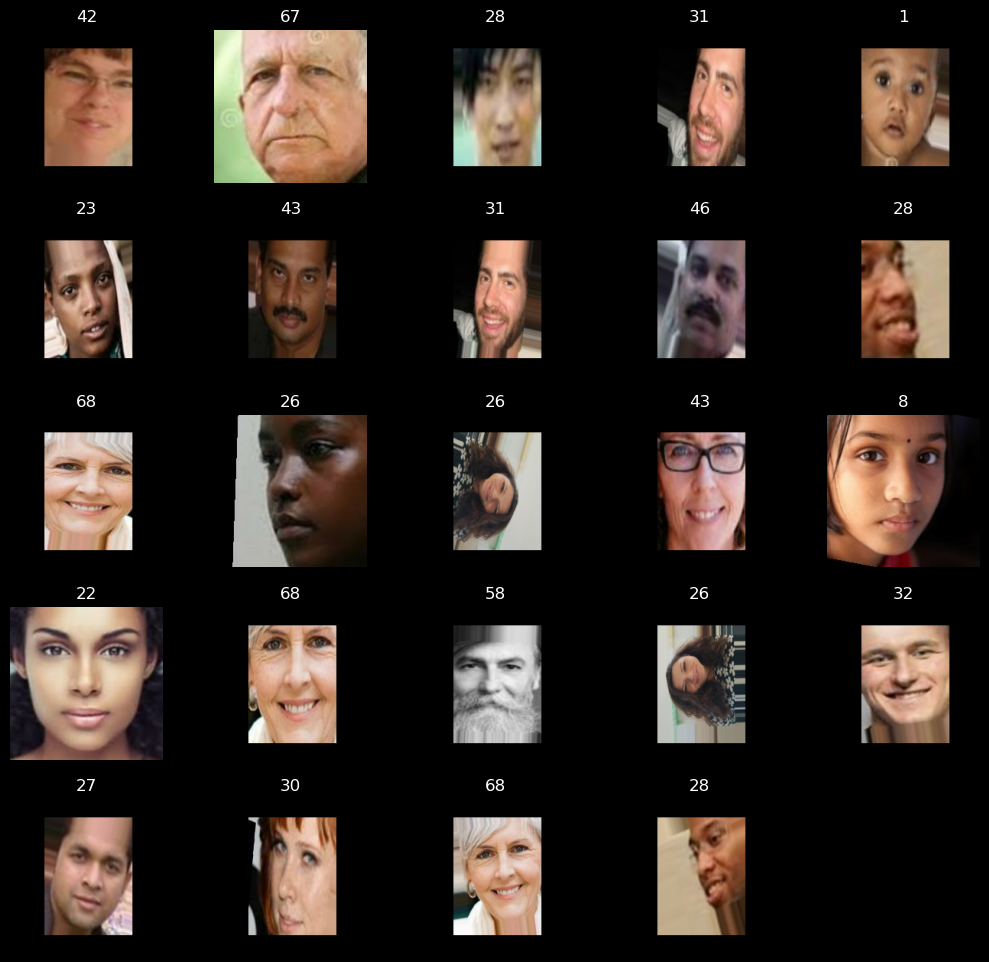

In [59]:
# showing simple batch
train_images, train_labels = next(data_train.as_numpy_iterator())
show_25_images(train_images, train_labels)

## model training

In [60]:
from tensorflow.keras.models import Model

#comment if loading model
#delete last layer
entry_model_output = entry_model.layers[-2].output

# adding last layer
new_output = Dense(1, activation='relu')(entry_model_output)

# creating new model
model = Model(inputs=entry_model.input, outputs=new_output)
# or
#model = tf.keras.models.load_model('./models1')

In [61]:
from tensorflow.keras.losses import MeanSquaredError
model.compile(optimizer='adam',loss=MeanSquaredError())
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 128)       7385

In [62]:
history = model.fit(x=data_train,
                      epochs=NUM_EPOCHS*2,
                      validation_data=data_valid,
                      callbacks=[callback_one])

Epoch 1/40
2035/2035 [==============================] - 85s 42ms/step - loss: 126.0346 - val_loss: 61.3816
Epoch 2/40
2035/2035 [==============================] - 85s 41ms/step - loss: 58.6926 - val_loss: 46.7404
Epoch 3/40
2035/2035 [==============================] - 86s 42ms/step - loss: 47.1906 - val_loss: 45.7052
Epoch 4/40
2035/2035 [==============================] - 85s 41ms/step - loss: 40.2066 - val_loss: 38.4773
Epoch 5/40
2035/2035 [==============================] - 85s 41ms/step - loss: 35.9753 - val_loss: 39.3797
Epoch 6/40
2035/2035 [==============================] - 85s 42ms/step - loss: 32.0454 - val_loss: 35.9435
Epoch 7/40
2035/2035 [==============================] - 85s 42ms/step - loss: 28.7492 - val_loss: 32.4220
Epoch 8/40
2035/2035 [==============================] - 85s 42ms/step - loss: 25.6716 - val_loss: 32.6210
Epoch 9/40
2035/2035 [==============================] - 85s 41ms/step - loss: 23.8805 - val_loss: 33.5786
Epoch 10/40
2035/2035 [======================

INFO:tensorflow:Assets written to: ./models1\assets


INFO:tensorflow:Assets written to: ./models1\assets


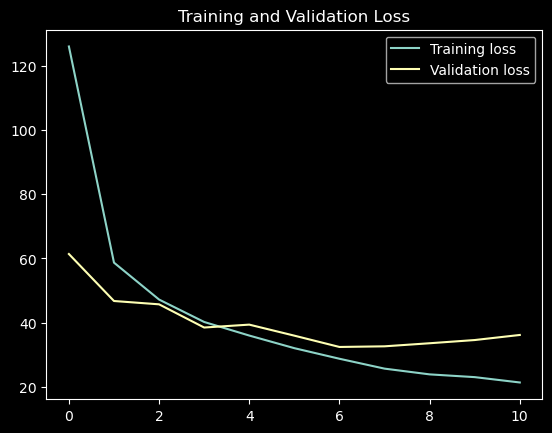

In [63]:
model.save("./models1")
plot_history_numeric(history)

In [64]:
model.evaluate(np.array(test_images),np.array(y_test))

108/108 [==============================] - 1s 7ms/step - loss: 89.7113


89.71129608154297

# Conclusion
Model is good, our loss function was mean squared error, which means our model is usually off in predictions by squareroot of 89 which is ~9,32 years, it's not that bad, with even more data and even bigger model, results would be better